In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
np.random.seed(12)
y = np.random.randint(0,4,300)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 80
1 72
2 75
3 73


In [3]:
x = np.zeros((300,2))

In [4]:
np.random.seed(12)
# covariance_matrix = np.eye(2)*0.01
# x[idx[0],:] = np.random.multivariate_normal(mean = [10,1],cov=covariance_matrix,size=sum(idx[0]))
# x[idx[1],:] = np.random.multivariate_normal(mean = [10,-1],cov=covariance_matrix,size=sum(idx[1]))
# x[idx[2],:] = np.random.multivariate_normal(mean = [15,0],cov=covariance_matrix,size=sum(idx[2]))
# x[idx[3],:] = np.random.multivariate_normal(mean = [-10,1],cov=np.eye(2)*0.5,size=sum(idx[3]))

x[idx[0],:] = np.random.uniform(low=[5,2],high=[6,4],size=(sum(idx[0]),2))

x[idx[1],:] = np.random.uniform(low=[5,-3],high=[6,-5],size=(sum(idx[1]),2))

x[idx[2],:] = np.random.uniform(low=[8,0],high=[9,-2],size=(sum(idx[2]),2))

x[idx[3],:] = np.random.uniform(low=[1,-1],high=[2,5],size=(sum(idx[3]),2))


In [5]:
x = (x-np.mean(x,axis=0,keepdims=True))/np.std(x,axis=0,keepdims=True)

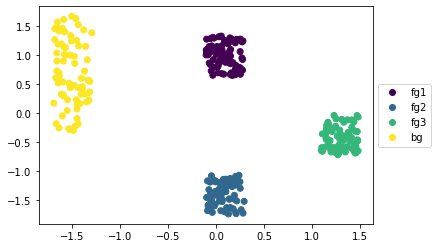

In [6]:
scatter = plt.scatter(x[:,0],x[:,1],c=y)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [7]:
desired_num = 1500
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 100
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1500/1500 [00:02<00:00, 551.17it/s]


In [8]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [9]:
batch = 250
training_size = 500
msd1 = MosaicDataset(mosaic_list_of_images[0:training_size], mosaic_label[0:training_size] , fore_idx[0:training_size])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

msd2 = MosaicDataset(mosaic_list_of_images[training_size:], mosaic_label[training_size:] , fore_idx[training_size:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [10]:
def my_cross_entropy(output,target,alpha,n_classes):
    if n_classes>2:
        criterion = nn.CrossEntropyLoss(reduce=False)
    else:
        criterion = nn.BCELoss(reduce=False)
    
    batch = output.size(0)
    patches = output.size(1)
    
    
    output = torch.reshape(output,(batch*patches,3))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    loss = torch.reshape(loss,(batch,patches))

    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)

    final_loss = torch.mean(final_loss,dim=0)
    return final_loss

In [11]:
def save_analysis(trainloader,testloader,focus,classification,n_classes):
    focus.eval()
    classification.eval()
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in trainloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
            #print(alphas[labels==0].shape,torch.max(alphas[labels==0],dim=1),"foreground",foregrnd_index[labels==0])
            #print(alphas[labels==1].shape,torch.max(alphas[labels==1],dim=1),"foreground",foregrnd_index[labels==1])
            #print(alphas[labels==2].shape,torch.max(alphas[labels==2],dim=1),"foreground",foregrnd_index[labels==2])
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)

    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    trn_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    fg_indexes = []
    alpha_argmax = []
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in testloader:
            inputs, labels,foregrnd_index = data
            inputs = inputs.double()
            inputs = inputs.to(device)
            alphas,attnd_inputs= focus(inputs)
            outputs = classification(attnd_inputs)
            if len(torch.unique(labels)) > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
                
            true_labels.append(labels)
            predicted_labels.append(predicted.cpu().numpy())
            index = torch.argmax(alphas,dim=1)
            fg_indexes.append(foregrnd_index.numpy())
            alpha_argmax.append(index.cpu().numpy())
    fg_indexes = np.concatenate(fg_indexes,axis=0)
    alpha_argmax = np.concatenate(alpha_argmax,axis=0)
    true_labels = np.concatenate(true_labels,axis=0)
    predicted_labels = np.concatenate(predicted_labels,axis=0)    
    ftpt = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels == true_labels))
    ffpt = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels == true_labels))
    ftpf = np.sum(np.logical_and(alpha_argmax == fg_indexes, predicted_labels != true_labels))
    ffpf = np.sum(np.logical_and(alpha_argmax != fg_indexes, predicted_labels != true_labels))
    tst_analysis = [ftpt,ffpt,ftpf,ffpf]
    
    
    return trn_analysis,tst_analysis

# soft attention

In [12]:
class Focus(nn.Module):
    def __init__(self,input_dims,attention,bias_=False,bn_=False):
        super(Focus, self).__init__()
        self.input_dims = input_dims 
        self.attention = attention
        self.bias_ = bias_
        self.fc1 = nn.Linear(self.input_dims,1, bias=self.bias_)
        self.bn_ = bn_
        if self.bn_:
            self.bn = nn.BatchNorm1d(input_dims)
        
    def forward_soft_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,self.input_dims)
        alp1,ft1 = self.helper(z)
        alpha = F.softmax(alp1,dim=1)
        y = torch.sum(alpha*ft1,dim=1)
        
        if self.bn_:
            y = self.bn(y)
        
        alpha =alpha[:,:,0]
        return alpha,y   # return  alpha values,attended data
    def forward_hard_Attention(self,z):
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            index = torch.argmax(alpha,dim=1)
            #print(index)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
        
    def forward(self,z): 
        if self.attention == "hard":
            alpha,y = self.forward_hard_Attention(z)
            return alpha,y
        elif self.attention == "soft":
            alpha,y = self.forward_soft_Attention(z)
            return alpha,y
        else:
            print("not correct Attention type")
            return None

    def helper(self, x):
        x1 = x
        x = self.fc1(x)
        return x,x1

In [13]:
class Classification(nn.Module):
    def __init__(self,input_dims,output_dims):
        super(Classification, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims 
        self.fc1 = nn.Linear(self.input_dims, self.output_dims)
    def forward(self, x):
        x = self.fc1(x)
        if self.output_dims ==1:
            x = torch.sigmoid(x)
        return x

In [14]:
def initialize_zeros_weights(m):
    if isinstance(m,nn.Linear):
        nn.init.zeros_(m.weight.data)
        if m.bias is not None:
            nn.init.zeros_(m.bias.data)

In [15]:
def train_attention_models(trainloader,focus_module,classification_module,
                           n_classes,nos_epochs,attention,learning_rate=0.01):
    
    
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classification_module.parameters(), lr=learning_rate)#,  momentum=0.09)
    optimizer_focus = optim.SGD(focus_module.parameters(), lr=learning_rate)# , momentum=0.09)
    loss_list=[]
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        focus_module.train()
        classification_module.train()
        for i, data in  enumerate(trainloader):
            inputs , labels , fore_idx = data
            batch = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.double()
            # zero the parameter gradients
            optimizer_focus.zero_grad()
            optimizer_classify.zero_grad()
            alphas, avg_images = focus_module(inputs)
            outputs = classification_module(avg_images)
            #print(outputs.shape)
            
            # predicted values
            if n_classes > 2:
                _,predicted= torch.max(outputs,dim=1)
            else:
                predicted = (outputs.data[:,0]>0.5).type(torch.int64)
            
            # calculate loss
            if attention == "soft":
                loss = criterion(outputs,labels)
            if attention == "hard":
                loss = my_cross_entropy(outputs,labels,alphas,n_classes)
            loss.backward()
            optimizer_focus.step()
            optimizer_classify.step()
            epoch_loss.append(loss.item())
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        if(np.mean(epoch_loss) <= 0.01):
            break
    print('Finished Training')
    return focus_module,classification_module,loss_list 


In [16]:
focus_net = Focus(input_dims = 2,attention="soft",bias_=False,bn_=False).double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [17]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([2, 162, 3, 333], [3, 319, 10, 668])

In [18]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="soft")

[1] loss: 1.101
[2] loss: 1.101
[3] loss: 1.101
[4] loss: 1.099
[5] loss: 1.100
[6] loss: 1.100
[7] loss: 1.102
[8] loss: 1.100
[9] loss: 1.099
[10] loss: 1.103
[11] loss: 1.099
[12] loss: 1.098
[13] loss: 1.100
[14] loss: 1.101
[15] loss: 1.100
[16] loss: 1.099
[17] loss: 1.101
[18] loss: 1.101
[19] loss: 1.099
[20] loss: 1.099
[21] loss: 1.100
[22] loss: 1.101
[23] loss: 1.100
[24] loss: 1.102
[25] loss: 1.099
[26] loss: 1.101
[27] loss: 1.099
[28] loss: 1.098
[29] loss: 1.099
[30] loss: 1.101
[31] loss: 1.100
[32] loss: 1.099
[33] loss: 1.098
[34] loss: 1.098
[35] loss: 1.101
[36] loss: 1.098
[37] loss: 1.099
[38] loss: 1.099
[39] loss: 1.098
[40] loss: 1.098
[41] loss: 1.098
[42] loss: 1.099
[43] loss: 1.098
[44] loss: 1.098
[45] loss: 1.098
[46] loss: 1.103
[47] loss: 1.102
[48] loss: 1.098
[49] loss: 1.098
[50] loss: 1.100
[51] loss: 1.098
[52] loss: 1.099
[53] loss: 1.098
[54] loss: 1.098
[55] loss: 1.100
[56] loss: 1.099
[57] loss: 1.098
[58] loss: 1.097
[59] loss: 1.098
[60] l

In [19]:
save_analysis(train_loader,test_loader,focus_net,classify,3)

([500, 0, 0, 0], [1000, 0, 0, 0])

In [20]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[ 2.9576, -1.4161]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-2.4726,  2.4983],
        [-1.3125, -3.4329],
        [ 3.7851,  0.9346]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 0.5328, -0.4950, -0.0378], dtype=torch.float64, requires_grad=True)


In [21]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False) 
        
        max_values_1,_ = torch.max(alphas[labels==1],dim=1)
        non_max_values_1,_ = torch.topk(alphas[labels==1],k=99,largest=False) 
        
        max_values_2,_ = torch.max(alphas[labels==2],dim=1)
        non_max_values_2,_ = torch.topk(alphas[labels==2],k=99,largest=False) 
        
        #print(alphas[np.arange(fore_idx.shape[0]),torch.argmax(alphas,dim=1)])
        attended_data.append(avg_images.numpy())
attended_data = np.concatenate(attended_data,axis=0)
labels_ = np.concatenate(labels_,axis=0)

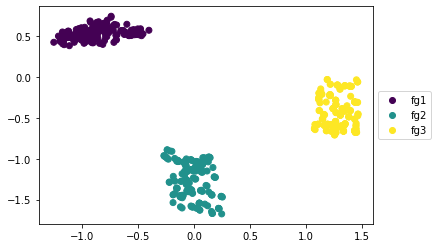

In [22]:
scatter = plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3"))

In [23]:
# scatter = plt.scatter(x[:,0],x[:,1],c=y)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#            handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))

In [24]:
# print(max_values)
# sorted_values,_ = torch.sort(non_max_values,descending=True)
# sorted_values[0,0:20]

In [25]:
# print(max_values_1)
# sorted_values,_ = torch.sort(non_max_values_1,descending=True)
# sorted_values[0,0:20]

In [26]:
# print(max_values_2)
# sorted_values,_ = torch.sort(non_max_values_2,descending=True)
# sorted_values[0,0:20]

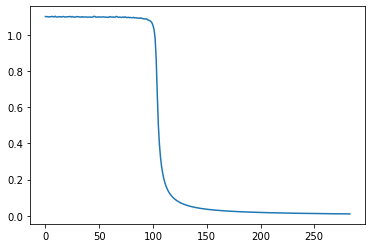

In [27]:
plt.plot(loss_list)

In [28]:
# attended_data

# hard attention

In [29]:
focus_net = Focus(input_dims = 2,attention="hard").double()
focus_net = focus_net.to(device)

classify = Classification(input_dims=2,output_dims=3).double()
classify = classify.to(device)

focus_net.apply(initialize_zeros_weights)
classify.apply(initialize_zeros_weights)
# parameters
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], dtype=torch.float64, requires_grad=True)


In [30]:
focus_net,classify,loss_list = train_attention_models(train_loader,focus_net,classify,
                           learning_rate=0.5,n_classes=3,nos_epochs=10000,attention="hard")

[1] loss: 1.103
[2] loss: 1.100
[3] loss: 1.100
[4] loss: 1.099
[5] loss: 1.102
[6] loss: 1.101
[7] loss: 1.099
[8] loss: 1.103
[9] loss: 1.101
[10] loss: 1.100
[11] loss: 1.099
[12] loss: 1.099
[13] loss: 1.100
[14] loss: 1.100
[15] loss: 1.099
[16] loss: 1.100


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[17] loss: 1.102
[18] loss: 1.101
[19] loss: 1.101
[20] loss: 1.101
[21] loss: 1.100
[22] loss: 1.101
[23] loss: 1.102
[24] loss: 1.101
[25] loss: 1.101
[26] loss: 1.104
[27] loss: 1.099
[28] loss: 1.102
[29] loss: 1.099
[30] loss: 1.102
[31] loss: 1.100
[32] loss: 1.100
[33] loss: 1.099
[34] loss: 1.098
[35] loss: 1.100
[36] loss: 1.106
[37] loss: 1.099
[38] loss: 1.099
[39] loss: 1.099
[40] loss: 1.100
[41] loss: 1.100
[42] loss: 1.099
[43] loss: 1.100
[44] loss: 1.099
[45] loss: 1.099
[46] loss: 1.100
[47] loss: 1.100
[48] loss: 1.103
[49] loss: 1.100
[50] loss: 1.101
[51] loss: 1.100
[52] loss: 1.101
[53] loss: 1.100
[54] loss: 1.101
[55] loss: 1.099
[56] loss: 1.104
[57] loss: 1.103
[58] loss: 1.100
[59] loss: 1.099
[60] loss: 1.098
[61] loss: 1.098
[62] loss: 1.098
[63] loss: 1.101
[64] loss: 1.099
[65] loss: 1.103
[66] loss: 1.102
[67] loss: 1.104
[68] loss: 1.102
[69] loss: 1.103
[70] loss: 1.101
[71] loss: 1.099
[72] loss: 1.099
[73] loss: 1.099
[74] loss: 1.100
[75] loss: 1.0

[485] loss: 0.011
[486] loss: 0.010
[487] loss: 0.010
[488] loss: 0.010
[489] loss: 0.010
[490] loss: 0.010
[491] loss: 0.010
[492] loss: 0.010
[493] loss: 0.010
[494] loss: 0.010
[495] loss: 0.010
[496] loss: 0.010
[497] loss: 0.010
[498] loss: 0.010
[499] loss: 0.010
[500] loss: 0.010
[501] loss: 0.010
Finished Training


In [31]:
save_analysis(train_loader,test_loader,focus_net,classify,3) # ftpt ffpt ftpf ffpf

([500, 0, 0, 0], [1000, 0, 0, 0])

In [32]:
attended_data = []
labels_ = []
focus_net.eval()
classify.eval()
with torch.no_grad():
    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        labels_.append(labels.numpy())
        # zero the parameter gradients
        alphas, avg_images = focus_net(inputs)
        max_values,_ = torch.max(alphas[labels==0],dim=1)
        non_max_values,_ = torch.topk(alphas[labels==0],k=99,largest=False)
        #print(alphas[np.arange(alphas.shape[0]),torch.argmax(alphas,dim=1)],torch.argmax(alphas,dim=1),fore_idx)
        outputs = torch.sigmoid(classify(avg_images))
        attended_data.append(avg_images.numpy())
#         loss = my_cross_entropy(outputs[:,0], labels.double(),alphas) 

In [33]:
attended_data = np.concatenate(attended_data,axis=0)
# labels_ = np.concatenate(labels_,axis=0)

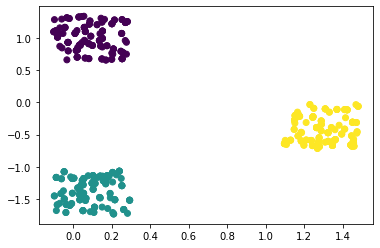

In [34]:
plt.scatter(attended_data[:,0],attended_data[:,1],c=labels_)

In [35]:
print(max_values)
sorted_values,_ = torch.sort(non_max_values,descending=True)
sorted_values[:,0:10]

tensor([0.6926, 0.6677, 0.4324, 0.7315, 0.7365, 0.8192, 0.6864, 0.6441, 0.5881,
        0.7321, 0.7867, 0.9283, 0.3936, 0.8805, 0.5689, 0.7573, 0.7935, 0.8770,
        0.7604, 0.6493, 0.6713, 0.7715, 0.6003, 0.5899, 0.4217, 0.4358, 0.7481,
        0.7666, 0.7150, 0.9292, 0.8428, 0.9191, 0.6981, 0.7421, 0.6801, 0.5766,
        0.4932, 0.7971, 0.8550, 0.7053, 0.4356, 0.6058, 0.5854, 0.7817, 0.3358,
        0.7319, 0.9042, 0.6330, 0.6454, 0.6967, 0.6824, 0.7346, 0.8001, 0.6939,
        0.4210, 0.9239, 0.7046, 0.5128, 0.6233, 0.5754, 0.9316, 0.7747, 0.5997,
        0.3857, 0.9152, 0.5621, 0.9377, 0.9282, 0.8226, 0.6878, 0.7424, 0.6569,
        0.4604, 0.6138, 0.7930, 0.7074, 0.3963, 0.7302, 0.6432, 0.9263],
       dtype=torch.float64)


tensor([[0.0147, 0.0147, 0.0147, 0.0134, 0.0134, 0.0134, 0.0134, 0.0116, 0.0116,
         0.0108],
        [0.0192, 0.0192, 0.0175, 0.0175, 0.0166, 0.0123, 0.0123, 0.0123, 0.0086,
         0.0086],
        [0.0272, 0.0272, 0.0248, 0.0248, 0.0236, 0.0236, 0.0236, 0.0236, 0.0236,
         0.0215],
        [0.0154, 0.0154, 0.0140, 0.0133, 0.0133, 0.0122, 0.0122, 0.0069, 0.0069,
         0.0066],
        [0.0154, 0.0154, 0.0146, 0.0133, 0.0123, 0.0108, 0.0108, 0.0108, 0.0076,
         0.0076],
        [0.0085, 0.0085, 0.0085, 0.0085, 0.0078, 0.0078, 0.0078, 0.0078, 0.0078,
         0.0074],
        [0.0171, 0.0171, 0.0171, 0.0156, 0.0156, 0.0156, 0.0148, 0.0135, 0.0109,
         0.0077],
        [0.0263, 0.0263, 0.0240, 0.0228, 0.0208, 0.0168, 0.0114, 0.0114, 0.0112,
         0.0102],
        [0.0264, 0.0264, 0.0209, 0.0193, 0.0169, 0.0169, 0.0169, 0.0169, 0.0119,
         0.0119],
        [0.0182, 0.0173, 0.0146, 0.0146, 0.0146, 0.0089, 0.0089, 0.0087, 0.0087,
         0.0087],
        [0

In [36]:
for params in focus_net.parameters():
    print(params)
for params in classify.parameters():
    print(params)

Parameter containing:
tensor([[ 4.7951, -3.0442]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[-3.0134,  3.3324],
        [-1.3528, -3.6621],
        [ 4.3662,  0.3297]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([ 2.0775, -0.8248, -1.2526], dtype=torch.float64, requires_grad=True)


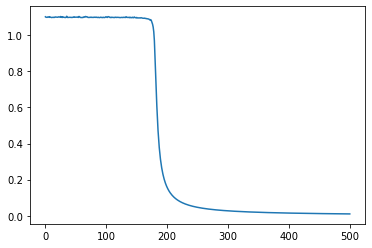

In [37]:
plt.plot(loss_list)

# train a max-margin classifier

In [38]:
fg_bg_labels = np.ones(y.shape)
fg_bg_labels[np.where(y==3)] = 0

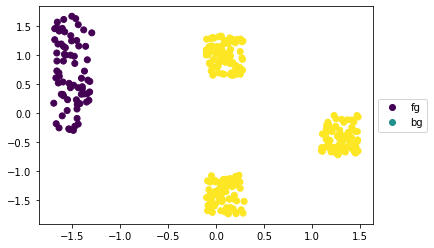

In [39]:
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))

In [40]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0,fit_intercept=True)
clf.fit(x,fg_bg_labels)

LinearSVC(random_state=0)

In [41]:
sum(clf.predict(x) == fg_bg_labels)

300

In [42]:
clf.coef_,clf.intercept_

(array([[ 1.49467446, -0.00920422]]), array([1.06334517]))

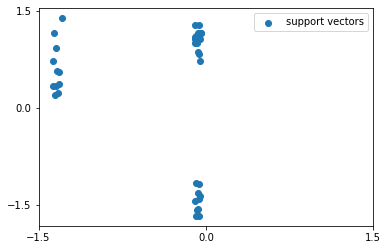

In [43]:
decision_function = clf.decision_function(x)
support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
support_vectors = x[support_vector_indices]
plt.scatter(support_vectors[:,0],support_vectors[:,1],label="support vectors")
plt.xticks([-1.5,0.0,1.5])
plt.yticks([-1.5,0.0,1.5])
plt.legend()


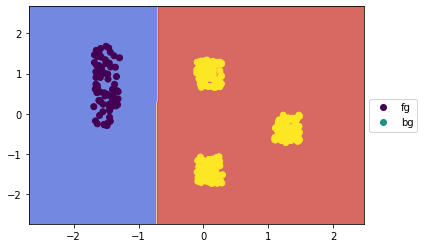

In [44]:
# create a mesh to plot in
h = 0.02
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(x[:,0],x[:,1],c=fg_bg_labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg","bg"))


In [45]:
beta = torch.tensor([0,0.01,0.02,0.04,0.08,0.16,0.32,0.50,0.64,1,1.28,2.56,5.12])
directions = torch.tensor([[1,0],[1/np.sqrt(2),1/np.sqrt(2)],[0,1],
              [-1/np.sqrt(2),1/np.sqrt(2)],[-1,0],[-1/np.sqrt(2),-1/np.sqrt(2)],[0,-1],[1/np.sqrt(2),-1/np.sqrt(2)]])

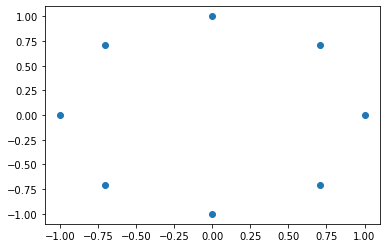

In [46]:
plt.scatter(directions[:,0],directions[:,1])

In [47]:
def generate_attended_data(trainloader,focus,focus_direction=None):
    attended_data = []
    attended_labels = []
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alphas, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)
            y = torch.sum(alpha*ft1,dim=1)
            alpha =alpha[:,:,0]
            avg_data = y
            
            
        attended_data.append(avg_data)
        attended_labels.append(labels)
    attended_data = torch.cat(attended_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    #plt.figure()
    #plt.scatter(attended_data[:,0],attended_data[:,1],c=attended_labels)
    return attended_data,attended_labels
        
    

In [48]:
def calculate_loss(data,labels,net,criterion):
    net.eval()
    with torch.no_grad():
        outputs = net(data)
        loss = criterion(outputs,labels)
    return loss.item()
        
        
        

In [49]:
def train_classification_model(attended_data,attended_labels, classify_model,n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCELoss()
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        outputs = classify_model(attended_data)
        loss = criterion(outputs,attended_labels)
        epoch_loss.append(loss.item())
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_inputs,test_labels = data
            classify_model.eval()
            test_outputs = classify_model(test_inputs)
            test_loss = criterion(test_outputs,test_labels)
            test_loss_epoch.append(test_loss.item())
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        outputs = classify_model(attended_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = criterion(outputs,attended_labels)
        loss.backward()
        optimizer_classify.step()
        
        loss_ = calculate_loss(attended_data,attended_labels,classify_model,criterion)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_inputs,test_labels = data
            test_loss = calculate_loss(test_inputs,test_labels,classify_model,criterion)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break    
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list
    
    

In [50]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="soft").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False
    

    
    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)
    

    
    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_attended_data,f_labels = generate_attended_data(train_loader,focus_net)
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_attended_data,f_labels])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="soft").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_attended_data,d_labels = generate_attended_data(train_loader,focus_net,focus_net_direction)

        test_attended_data.append([d_attended_data,d_labels])

        
        
    
    _,loss_list,test_loss_list = train_classification_model(f_attended_data,f_labels,classify,
                                             n_classes=3,test_list=test_attended_data,learning_rate=0.5)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)
        
    

    

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.099
[2] loss: 1.099
[3] loss: 1.099
[4] loss: 1.099
[5] loss: 1.099
[6] loss: 1.099
[7] loss: 1.098
[8] loss: 1.098
[9] loss: 1.098
[10] loss: 1.098
[11] loss: 1.098
[12] loss: 1.098
[13] loss: 1.098
[14] loss: 1.098
[15] loss: 1.098
[16] loss: 1.098
[17] loss: 1.098
[18] loss: 1.098
[19] loss: 1.098
[20] loss: 1.098
[21] loss: 1.098
[22] loss: 1.098
[23] loss: 1.098
[24] loss: 1.098
[25] loss: 1.098
[26] loss: 1.098
[27] loss: 1.098
[28] loss: 1.098
[29] loss: 1.098
[30] loss: 1.098
[31] loss: 1.098
[32] loss: 1.098
[33] loss: 1.098
[34] loss: 1.098
[35] loss: 1.098
[36] loss: 1.098
[37] loss: 1.098
[38] loss: 1.098
[39] loss: 1.098
[40] loss: 1.098
[41] loss: 1.098
[42] loss: 1.098
[43] loss: 1.098
[44] loss: 1.098
[45] loss: 1.098
[46] loss: 1.098
[47] loss: 1.098
[48] loss: 1.098
[49] loss: 1.098
[50] loss: 1.098
[51] loss: 1.098
[52] loss: 1.098

[211] loss: 1.097
[212] loss: 1.096
[213] loss: 1.096
[214] loss: 1.096
[215] loss: 1.096
[216] loss: 1.096
[217] loss: 1.096
[218] loss: 1.096
[219] loss: 1.096
[220] loss: 1.096
[221] loss: 1.096
[222] loss: 1.096
[223] loss: 1.096
[224] loss: 1.096
[225] loss: 1.096
[226] loss: 1.096
[227] loss: 1.096
[228] loss: 1.096
[229] loss: 1.096
[230] loss: 1.096
[231] loss: 1.096
[232] loss: 1.096
[233] loss: 1.096
[234] loss: 1.096
[235] loss: 1.096
[236] loss: 1.096
[237] loss: 1.096
[238] loss: 1.096
[239] loss: 1.096
[240] loss: 1.096
[241] loss: 1.096
[242] loss: 1.096
[243] loss: 1.096
[244] loss: 1.096
[245] loss: 1.096
[246] loss: 1.096
[247] loss: 1.096
[248] loss: 1.096
[249] loss: 1.096
[250] loss: 1.096
[251] loss: 1.096
[252] loss: 1.096
[253] loss: 1.096
[254] loss: 1.096
[255] loss: 1.096
[256] loss: 1.096
[257] loss: 1.096
[258] loss: 1.096
[259] loss: 1.096
[260] loss: 1.096
[261] loss: 1.096
[262] loss: 1.096
[263] loss: 1.096
[264] loss: 1.096
[265] loss: 1.096
[266] loss

[135] loss: 1.097
[136] loss: 1.097
[137] loss: 1.097
[138] loss: 1.097
[139] loss: 1.097
[140] loss: 1.097
[141] loss: 1.097
[142] loss: 1.097
[143] loss: 1.097
[144] loss: 1.097
[145] loss: 1.097
[146] loss: 1.097
[147] loss: 1.097
[148] loss: 1.097
[149] loss: 1.097
[150] loss: 1.097
[151] loss: 1.097
[152] loss: 1.097
[153] loss: 1.097
[154] loss: 1.097
[155] loss: 1.097
[156] loss: 1.097
[157] loss: 1.097
[158] loss: 1.097
[159] loss: 1.097
[160] loss: 1.097
[161] loss: 1.097
[162] loss: 1.097
[163] loss: 1.097
[164] loss: 1.097
[165] loss: 1.097
[166] loss: 1.097
[167] loss: 1.097
[168] loss: 1.097
[169] loss: 1.097
[170] loss: 1.097
[171] loss: 1.097
[172] loss: 1.097
[173] loss: 1.097
[174] loss: 1.097
[175] loss: 1.097
[176] loss: 1.097
[177] loss: 1.097
[178] loss: 1.097
[179] loss: 1.097
[180] loss: 1.097
[181] loss: 1.097
[182] loss: 1.096
[183] loss: 1.096
[184] loss: 1.096
[185] loss: 1.096
[186] loss: 1.096
[187] loss: 1.096
[188] loss: 1.096
[189] loss: 1.096
[190] loss

[72] loss: 1.097
[73] loss: 1.097
[74] loss: 1.097
[75] loss: 1.097
[76] loss: 1.097
[77] loss: 1.097
[78] loss: 1.097
[79] loss: 1.097
[80] loss: 1.097
[81] loss: 1.097
[82] loss: 1.097
[83] loss: 1.097
[84] loss: 1.097
[85] loss: 1.097
[86] loss: 1.097
[87] loss: 1.097
[88] loss: 1.097
[89] loss: 1.097
[90] loss: 1.097
[91] loss: 1.097
[92] loss: 1.097
[93] loss: 1.097
[94] loss: 1.097
[95] loss: 1.097
[96] loss: 1.097
[97] loss: 1.097
[98] loss: 1.097
[99] loss: 1.096
[100] loss: 1.096
[101] loss: 1.096
[102] loss: 1.096
[103] loss: 1.096
[104] loss: 1.096
[105] loss: 1.096
[106] loss: 1.096
[107] loss: 1.096
[108] loss: 1.096
[109] loss: 1.096
[110] loss: 1.096
[111] loss: 1.096
[112] loss: 1.096
[113] loss: 1.096
[114] loss: 1.096
[115] loss: 1.096
[116] loss: 1.096
[117] loss: 1.096
[118] loss: 1.096
[119] loss: 1.096
[120] loss: 1.096
[121] loss: 1.096
[122] loss: 1.096
[123] loss: 1.096
[124] loss: 1.096
[125] loss: 1.096
[126] loss: 1.096
[127] loss: 1.096
[128] loss: 1.096
[1

[2] loss: 1.098
[3] loss: 1.098
[4] loss: 1.098
[5] loss: 1.098
[6] loss: 1.098
[7] loss: 1.098
[8] loss: 1.098
[9] loss: 1.097
[10] loss: 1.097
[11] loss: 1.097
[12] loss: 1.097
[13] loss: 1.097
[14] loss: 1.097
[15] loss: 1.097
[16] loss: 1.097
[17] loss: 1.096
[18] loss: 1.096
[19] loss: 1.096
[20] loss: 1.096
[21] loss: 1.096
[22] loss: 1.096
[23] loss: 1.096
[24] loss: 1.096
[25] loss: 1.095
[26] loss: 1.095
[27] loss: 1.095
[28] loss: 1.095
[29] loss: 1.095
[30] loss: 1.095
[31] loss: 1.095
[32] loss: 1.095
[33] loss: 1.095
[34] loss: 1.094
[35] loss: 1.094
[36] loss: 1.094
[37] loss: 1.094
[38] loss: 1.094
[39] loss: 1.094
[40] loss: 1.094
[41] loss: 1.094
[42] loss: 1.093
[43] loss: 1.093
[44] loss: 1.093
[45] loss: 1.093
[46] loss: 1.093
[47] loss: 1.093
[48] loss: 1.093
[49] loss: 1.093
[50] loss: 1.092
[51] loss: 1.092
[52] loss: 1.092
[53] loss: 1.092
[54] loss: 1.092
[55] loss: 1.092
[56] loss: 1.092
[57] loss: 1.092
[58] loss: 1.092
[59] loss: 1.091
[60] loss: 1.091
[61] 

[251] loss: 1.038
[252] loss: 1.038
[253] loss: 1.038
[254] loss: 1.037
[255] loss: 1.037
[256] loss: 1.037
[257] loss: 1.037
[258] loss: 1.036
[259] loss: 1.036
[260] loss: 1.036
[261] loss: 1.036
[262] loss: 1.036
[263] loss: 1.035
[264] loss: 1.035
[265] loss: 1.035
[266] loss: 1.035
[267] loss: 1.034
[268] loss: 1.034
[269] loss: 1.034
[270] loss: 1.034
[271] loss: 1.034
[272] loss: 1.033
[273] loss: 1.033
[274] loss: 1.033
[275] loss: 1.033
[276] loss: 1.032
[277] loss: 1.032
[278] loss: 1.032
[279] loss: 1.032
[280] loss: 1.032
[281] loss: 1.031
[282] loss: 1.031
[283] loss: 1.031
[284] loss: 1.031
[285] loss: 1.030
[286] loss: 1.030
[287] loss: 1.030
[288] loss: 1.030
[289] loss: 1.030
[290] loss: 1.029
[291] loss: 1.029
[292] loss: 1.029
[293] loss: 1.029
[294] loss: 1.029
[295] loss: 1.028
[296] loss: 1.028
[297] loss: 1.028
[298] loss: 1.028
[299] loss: 1.027
[300] loss: 1.027
Finished Training
301 301
Parameters
('fc1.weight', Parameter containing:
tensor([[ 1.0000, -0.0062]

[173] loss: 0.547
[174] loss: 0.545
[175] loss: 0.544
[176] loss: 0.543
[177] loss: 0.542
[178] loss: 0.540
[179] loss: 0.539
[180] loss: 0.538
[181] loss: 0.537
[182] loss: 0.536
[183] loss: 0.534
[184] loss: 0.533
[185] loss: 0.532
[186] loss: 0.531
[187] loss: 0.530
[188] loss: 0.529
[189] loss: 0.528
[190] loss: 0.526
[191] loss: 0.525
[192] loss: 0.524
[193] loss: 0.523
[194] loss: 0.522
[195] loss: 0.521
[196] loss: 0.520
[197] loss: 0.519
[198] loss: 0.518
[199] loss: 0.517
[200] loss: 0.516
[201] loss: 0.515
[202] loss: 0.513
[203] loss: 0.512
[204] loss: 0.511
[205] loss: 0.510
[206] loss: 0.509
[207] loss: 0.508
[208] loss: 0.507
[209] loss: 0.506
[210] loss: 0.505
[211] loss: 0.504
[212] loss: 0.503
[213] loss: 0.502
[214] loss: 0.501
[215] loss: 0.500
[216] loss: 0.499
[217] loss: 0.499
[218] loss: 0.498
[219] loss: 0.497
[220] loss: 0.496
[221] loss: 0.495
[222] loss: 0.494
[223] loss: 0.493
[224] loss: 0.492
[225] loss: 0.491
[226] loss: 0.490
[227] loss: 0.489
[228] loss

[94] loss: 0.040
[95] loss: 0.039
[96] loss: 0.039
[97] loss: 0.039
[98] loss: 0.038
[99] loss: 0.038
[100] loss: 0.038
[101] loss: 0.037
[102] loss: 0.037
[103] loss: 0.036
[104] loss: 0.036
[105] loss: 0.036
[106] loss: 0.035
[107] loss: 0.035
[108] loss: 0.035
[109] loss: 0.035
[110] loss: 0.034
[111] loss: 0.034
[112] loss: 0.034
[113] loss: 0.033
[114] loss: 0.033
[115] loss: 0.033
[116] loss: 0.033
[117] loss: 0.032
[118] loss: 0.032
[119] loss: 0.032
[120] loss: 0.031
[121] loss: 0.031
[122] loss: 0.031
[123] loss: 0.031
[124] loss: 0.031
[125] loss: 0.030
[126] loss: 0.030
[127] loss: 0.030
[128] loss: 0.030
[129] loss: 0.029
[130] loss: 0.029
[131] loss: 0.029
[132] loss: 0.029
[133] loss: 0.029
[134] loss: 0.028
[135] loss: 0.028
[136] loss: 0.028
[137] loss: 0.028
[138] loss: 0.028
[139] loss: 0.027
[140] loss: 0.027
[141] loss: 0.027
[142] loss: 0.027
[143] loss: 0.027
[144] loss: 0.026
[145] loss: 0.026
[146] loss: 0.026
[147] loss: 0.026
[148] loss: 0.026
[149] loss: 0.02

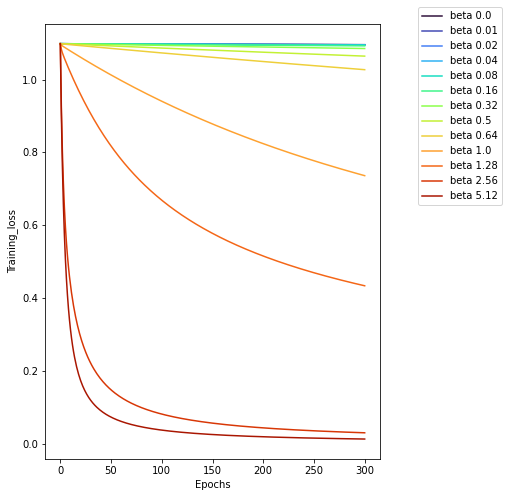

In [51]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("cin_train_loss_2.png",bbox_inches='tight')

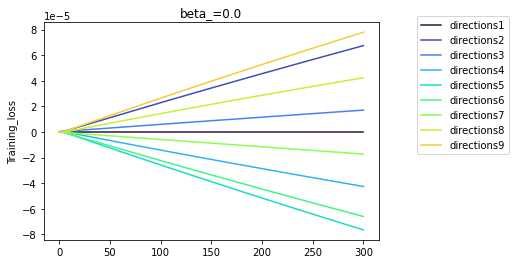

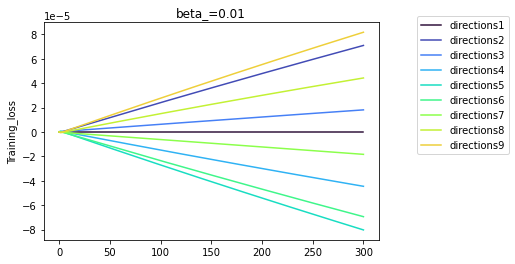

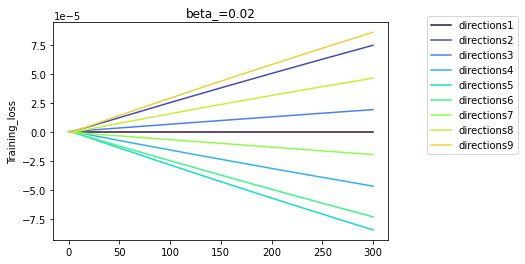

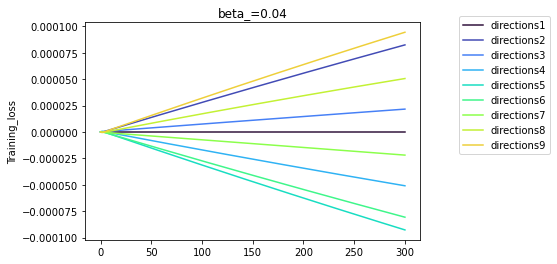

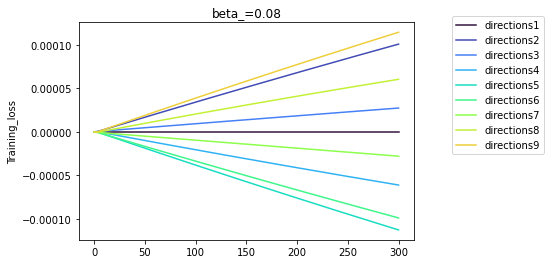

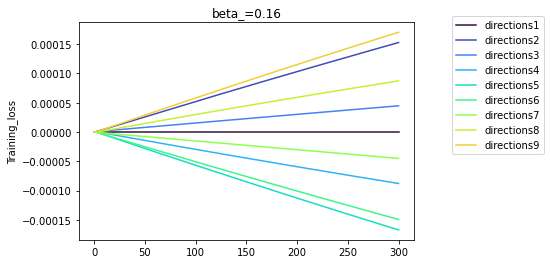

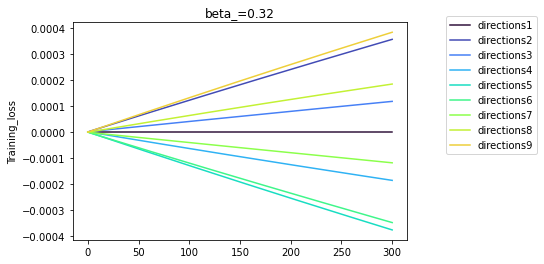

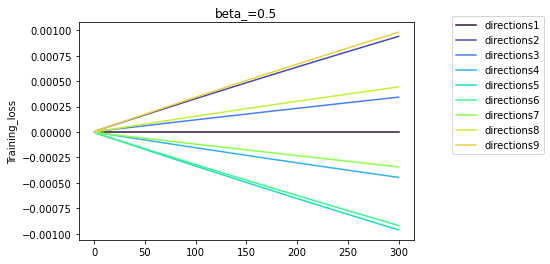

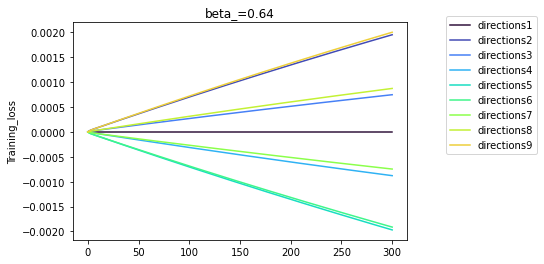

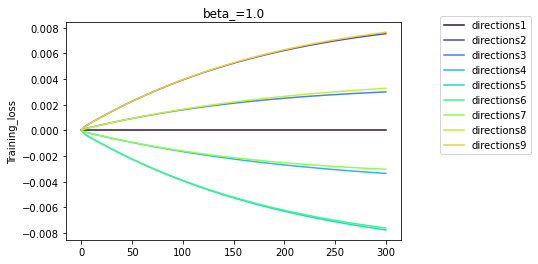

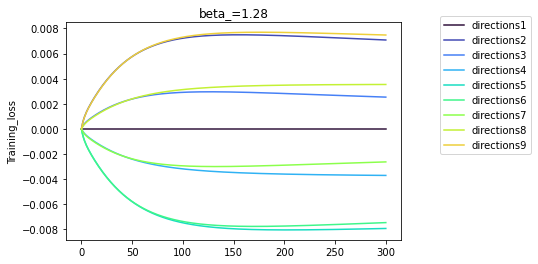

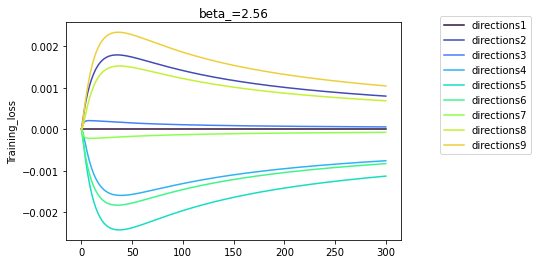

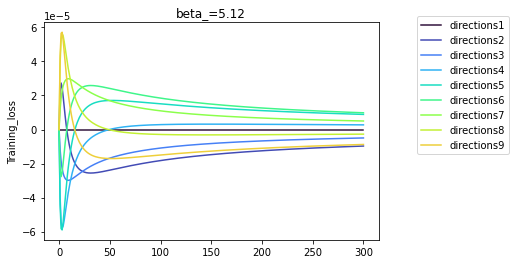

In [52]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("cin_train_loss_2_loss_beta_"+str(j)+".png",bbox_inches='tight')

In [53]:
# test_loss_beta

In [54]:
# test_loss_beta[0][:,1]

In [55]:
def hard_attention_generate_attended_data(trainloader,focus,focus_direction=None):
    mosaic_data = [] 
    attended_labels = []
    alpha_data = []
    
    for i, data in  enumerate(trainloader):
        inputs , labels , fore_idx = data
        batch = inputs.size(0)
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.double()
        if focus_direction is None:
            alpha, avg_data = focus(inputs)
        else:
            z = inputs
            batch = z.size(0)
            patches = z.size(1)
            dims = z.size(2)
            z = z.view(batch,patches,dims)
            alp1,ft1 = focus.helper(z)
            alp2,ft2 = focus_direction.helper(z)
            alp3 = alp1 + alp2
            alpha = F.softmax(alp3,dim=1)[:,:,0]
        mosaic_data.append(inputs)
        attended_labels.append(labels)
        alpha_data.append(alpha)
        
    mosaic_data = torch.cat(mosaic_data,dim=0)
    attended_labels = torch.cat(attended_labels,dim=0)
    alpha_data = torch.cat(alpha_data,dim=0)
    return mosaic_data,attended_labels,alpha_data
        

In [56]:
def hard_attention_calculate_loss(data,labels,alphas,net,criterion,train_mode=True):
    if train_mode:
        net.train()
        outputs = net(data)
        batch = outputs.size(0)
        patches = outputs.size(1)
        classes = outputs.size(2)
        
        outputs = torch.reshape(outputs,(batch*patches,classes))
        labels = labels.repeat_interleave(patches)
        loss = criterion(outputs,labels)
        loss = torch.reshape(loss,(batch,patches))
        loss = torch.mul(alphas,loss)
        loss = torch.sum(loss,dim=1)
        loss = torch.mean(loss)
        return loss
    else:  
        net.eval()
        with torch.no_grad():
            outputs = net(data)
            batch = outputs.size(0)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes))
            labels = labels.repeat_interleave(patches)
            loss = criterion(outputs,labels)
            loss = torch.reshape(loss,(batch,patches))
            loss = torch.mul(alphas,loss)
            loss = torch.sum(loss,dim=1)
            loss = torch.mean(loss)
            return loss.item()
        

In [57]:
def train_hard_attention_classification_model(mosaic_data,mosaic_labels,alphas,classify_model,
                               n_classes,test_list,learning_rate=0.01):
    nos_epochs = 300
    if n_classes > 2:
        criterion = nn.CrossEntropyLoss(reduction="none")
    else:
        criterion = nn.BCELoss(reduction="none")
    optimizer_classify = optim.SGD(classify_model.parameters(), lr=learning_rate)#,  momentum=0.09)
    loss_list=[]
    test_loss_list = []
    #print("ddd",attended_data,attended_labels)
    #print("sss",test_list[0])
    with torch.no_grad():
        test_loss_epoch  = [] 
        epoch_loss = []
        
        # for train data at epoch zero
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=False)
        
        epoch_loss.append(loss)
        # for test data at epoch zero
        test_loss_epoch  = [] 
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            #print(test_mosaic_data.shape,test_mosaic_labels.shape,test_alphas.shape)
            
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,
                                                      test_alphas,classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)
    loss_list.append(np.mean(epoch_loss))
        
    
    
    for epoch in range(nos_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_loss = []
        test_loss_epoch  = [] 
        classify_model.train()
        # zero the parameter gradients
        optimizer_classify.zero_grad()
        #outputs = classify_model(mosaic_data)
        #print(outputs.shape)
        # predicted values
        if n_classes > 2:
            _,predicted= torch.max(outputs,dim=1)
        else:
            predicted = (outputs.data[:,0]>0.5).type(torch.int64)
        loss = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                             alphas,classify_model,criterion,train_mode=True)
        loss.backward()
        optimizer_classify.step()
        loss_ = hard_attention_calculate_loss(mosaic_data,mosaic_labels,
                                              alphas,classify_model,criterion,train_mode=False)
        epoch_loss.append(loss_)
        print('[%d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss)))
        loss_list.append(np.mean(epoch_loss))
        # loss for test list, At every epoch for every direction perform forward pass and calculate loss
        for data in test_list:
            test_mosaic_data,test_mosaic_labels,test_alphas = data
            test_loss = hard_attention_calculate_loss(test_mosaic_data,test_mosaic_labels,test_alphas,
                                       classify_model,criterion,train_mode=False)
            test_loss_epoch.append(test_loss)
        test_loss_list.append(test_loss_epoch)    
        if(np.mean(epoch_loss) <= 0.01):
            break    
    print('Finished Training')
    print(len(loss_list),len(test_loss_list))
    return classify_model,loss_list,test_loss_list

In [58]:
weight = torch.tensor([[1.49467446, -0.00920422]],dtype=torch.float64)
weight = weight/torch.linalg.norm(weight)
print(torch.linalg.norm(weight))
loss_beta = []
test_loss_beta = []
for beta_ in beta:
    focus_net = Focus(input_dims = 2,attention="hard").double()
    focus_net = focus_net.to(device)
    focus_net.fc1.weight.data = beta_*weight
    focus_net.fc1.weight.requires_grad = False
    

    
    classify = Classification(input_dims=2,output_dims=3).double()
    classify.apply(initialize_zeros_weights)
    classify = classify.to(device)
    

    
    print("Parameters")
    
    for params in focus_net.named_parameters():
        print(params)
    
    # attended data for focus model 
    f_mosaic_data,f_mosaic_labels,f_alphas =  hard_attention_generate_attended_data(train_loader,focus_net)
    
    
    # test attended data for focus model with 8 directions
    test_attended_data = []
    test_attended_data.append([f_mosaic_data,f_mosaic_labels,f_alphas])
    
    for u in directions:
        focus_net_direction = Focus(input_dims = 2,attention="hard").double()
        focus_net_direction = focus_net_direction.to(device)
        focus_net_direction.fc1.weight.data = 0.01*u[None,:]
        focus_net_direction.fc1.weight.requires_grad = False
        d_mosaic_data,d_mosaic_labels,d_alphas =  hard_attention_generate_attended_data(train_loader,
                                                                                        focus_net,
                                                                                        focus_net_direction)

        test_attended_data.append([d_mosaic_data,d_mosaic_labels,d_alphas ])

        
        
    
    _,loss_list,test_loss_list = train_hard_attention_classification_model(f_mosaic_data,f_mosaic_labels,
                                                                          f_alphas,classify,n_classes=3,
                                                                          test_list=test_attended_data,
                                                                          learning_rate=0.5)
    
    test_loss_list = np.array(test_loss_list)
    
    loss_beta.append(loss_list)
    test_loss_beta.append(test_loss_list)

tensor(1.0000, dtype=torch.float64)
Parameters
('fc1.weight', Parameter containing:
tensor([[0., -0.]], dtype=torch.float64))
[1] loss: 1.099
[2] loss: 1.099
[3] loss: 1.099
[4] loss: 1.099
[5] loss: 1.099
[6] loss: 1.099
[7] loss: 1.099
[8] loss: 1.099
[9] loss: 1.098
[10] loss: 1.098
[11] loss: 1.098
[12] loss: 1.098
[13] loss: 1.098
[14] loss: 1.098
[15] loss: 1.098
[16] loss: 1.098
[17] loss: 1.098
[18] loss: 1.098
[19] loss: 1.098
[20] loss: 1.098
[21] loss: 1.098
[22] loss: 1.098
[23] loss: 1.098
[24] loss: 1.098
[25] loss: 1.098
[26] loss: 1.098
[27] loss: 1.098
[28] loss: 1.098
[29] loss: 1.098
[30] loss: 1.098
[31] loss: 1.098
[32] loss: 1.098
[33] loss: 1.098
[34] loss: 1.098
[35] loss: 1.098
[36] loss: 1.098
[37] loss: 1.098
[38] loss: 1.098
[39] loss: 1.098
[40] loss: 1.098
[41] loss: 1.098
[42] loss: 1.098
[43] loss: 1.098
[44] loss: 1.098
[45] loss: 1.098
[46] loss: 1.098
[47] loss: 1.098
[48] loss: 1.098
[49] loss: 1.098
[50] loss: 1.098
[51] loss: 1.098
[52] loss: 1.098

[159] loss: 1.098
[160] loss: 1.098
[161] loss: 1.098
[162] loss: 1.098
[163] loss: 1.098
[164] loss: 1.098
[165] loss: 1.098
[166] loss: 1.098
[167] loss: 1.098
[168] loss: 1.098
[169] loss: 1.098
[170] loss: 1.098
[171] loss: 1.098
[172] loss: 1.098
[173] loss: 1.098
[174] loss: 1.098
[175] loss: 1.098
[176] loss: 1.098
[177] loss: 1.098
[178] loss: 1.098
[179] loss: 1.098
[180] loss: 1.098
[181] loss: 1.098
[182] loss: 1.098
[183] loss: 1.098
[184] loss: 1.098
[185] loss: 1.098
[186] loss: 1.098
[187] loss: 1.098
[188] loss: 1.098
[189] loss: 1.098
[190] loss: 1.098
[191] loss: 1.098
[192] loss: 1.098
[193] loss: 1.098
[194] loss: 1.098
[195] loss: 1.098
[196] loss: 1.098
[197] loss: 1.098
[198] loss: 1.098
[199] loss: 1.098
[200] loss: 1.098
[201] loss: 1.098
[202] loss: 1.098
[203] loss: 1.098
[204] loss: 1.098
[205] loss: 1.098
[206] loss: 1.098
[207] loss: 1.098
[208] loss: 1.098
[209] loss: 1.098
[210] loss: 1.098
[211] loss: 1.098
[212] loss: 1.098
[213] loss: 1.098
[214] loss

[7] loss: 1.098
[8] loss: 1.098
[9] loss: 1.098
[10] loss: 1.098
[11] loss: 1.098
[12] loss: 1.098
[13] loss: 1.098
[14] loss: 1.098
[15] loss: 1.098
[16] loss: 1.098
[17] loss: 1.098
[18] loss: 1.098
[19] loss: 1.098
[20] loss: 1.098
[21] loss: 1.098
[22] loss: 1.098
[23] loss: 1.098
[24] loss: 1.098
[25] loss: 1.098
[26] loss: 1.098
[27] loss: 1.098
[28] loss: 1.098
[29] loss: 1.098
[30] loss: 1.098
[31] loss: 1.098
[32] loss: 1.098
[33] loss: 1.098
[34] loss: 1.098
[35] loss: 1.098
[36] loss: 1.098
[37] loss: 1.098
[38] loss: 1.098
[39] loss: 1.098
[40] loss: 1.098
[41] loss: 1.098
[42] loss: 1.098
[43] loss: 1.098
[44] loss: 1.098
[45] loss: 1.098
[46] loss: 1.098
[47] loss: 1.098
[48] loss: 1.098
[49] loss: 1.098
[50] loss: 1.098
[51] loss: 1.098
[52] loss: 1.098
[53] loss: 1.098
[54] loss: 1.098
[55] loss: 1.098
[56] loss: 1.098
[57] loss: 1.098
[58] loss: 1.098
[59] loss: 1.098
[60] loss: 1.098
[61] loss: 1.098
[62] loss: 1.098
[63] loss: 1.098
[64] loss: 1.098
[65] loss: 1.098


[174] loss: 1.098
[175] loss: 1.098
[176] loss: 1.098
[177] loss: 1.098
[178] loss: 1.098
[179] loss: 1.098
[180] loss: 1.098
[181] loss: 1.098
[182] loss: 1.098
[183] loss: 1.098
[184] loss: 1.098
[185] loss: 1.098
[186] loss: 1.098
[187] loss: 1.098
[188] loss: 1.098
[189] loss: 1.098
[190] loss: 1.098
[191] loss: 1.098
[192] loss: 1.098
[193] loss: 1.098
[194] loss: 1.098
[195] loss: 1.098
[196] loss: 1.098
[197] loss: 1.098
[198] loss: 1.098
[199] loss: 1.098
[200] loss: 1.098
[201] loss: 1.098
[202] loss: 1.098
[203] loss: 1.098
[204] loss: 1.098
[205] loss: 1.098
[206] loss: 1.098
[207] loss: 1.098
[208] loss: 1.098
[209] loss: 1.098
[210] loss: 1.098
[211] loss: 1.098
[212] loss: 1.098
[213] loss: 1.098
[214] loss: 1.098
[215] loss: 1.098
[216] loss: 1.098
[217] loss: 1.098
[218] loss: 1.098
[219] loss: 1.098
[220] loss: 1.098
[221] loss: 1.098
[222] loss: 1.098
[223] loss: 1.098
[224] loss: 1.098
[225] loss: 1.098
[226] loss: 1.098
[227] loss: 1.098
[228] loss: 1.098
[229] loss

[25] loss: 1.098
[26] loss: 1.098
[27] loss: 1.098
[28] loss: 1.098
[29] loss: 1.098
[30] loss: 1.098
[31] loss: 1.098
[32] loss: 1.098
[33] loss: 1.098
[34] loss: 1.098
[35] loss: 1.098
[36] loss: 1.098
[37] loss: 1.098
[38] loss: 1.098
[39] loss: 1.098
[40] loss: 1.098
[41] loss: 1.098
[42] loss: 1.098
[43] loss: 1.098
[44] loss: 1.098
[45] loss: 1.098
[46] loss: 1.098
[47] loss: 1.098
[48] loss: 1.098
[49] loss: 1.098
[50] loss: 1.098
[51] loss: 1.098
[52] loss: 1.097
[53] loss: 1.097
[54] loss: 1.097
[55] loss: 1.097
[56] loss: 1.097
[57] loss: 1.097
[58] loss: 1.097
[59] loss: 1.097
[60] loss: 1.097
[61] loss: 1.097
[62] loss: 1.097
[63] loss: 1.097
[64] loss: 1.097
[65] loss: 1.097
[66] loss: 1.097
[67] loss: 1.097
[68] loss: 1.097
[69] loss: 1.097
[70] loss: 1.097
[71] loss: 1.097
[72] loss: 1.097
[73] loss: 1.097
[74] loss: 1.097
[75] loss: 1.097
[76] loss: 1.097
[77] loss: 1.097
[78] loss: 1.097
[79] loss: 1.097
[80] loss: 1.097
[81] loss: 1.097
[82] loss: 1.097
[83] loss: 1.0

[192] loss: 1.094
[193] loss: 1.094
[194] loss: 1.094
[195] loss: 1.094
[196] loss: 1.094
[197] loss: 1.094
[198] loss: 1.094
[199] loss: 1.094
[200] loss: 1.094
[201] loss: 1.094
[202] loss: 1.094
[203] loss: 1.094
[204] loss: 1.094
[205] loss: 1.094
[206] loss: 1.094
[207] loss: 1.094
[208] loss: 1.094
[209] loss: 1.094
[210] loss: 1.094
[211] loss: 1.094
[212] loss: 1.094
[213] loss: 1.094
[214] loss: 1.094
[215] loss: 1.094
[216] loss: 1.094
[217] loss: 1.094
[218] loss: 1.094
[219] loss: 1.094
[220] loss: 1.094
[221] loss: 1.094
[222] loss: 1.094
[223] loss: 1.094
[224] loss: 1.094
[225] loss: 1.094
[226] loss: 1.094
[227] loss: 1.094
[228] loss: 1.094
[229] loss: 1.094
[230] loss: 1.094
[231] loss: 1.094
[232] loss: 1.094
[233] loss: 1.094
[234] loss: 1.094
[235] loss: 1.094
[236] loss: 1.094
[237] loss: 1.094
[238] loss: 1.094
[239] loss: 1.094
[240] loss: 1.094
[241] loss: 1.094
[242] loss: 1.094
[243] loss: 1.094
[244] loss: 1.094
[245] loss: 1.094
[246] loss: 1.094
[247] loss

[50] loss: 1.071
[51] loss: 1.071
[52] loss: 1.071
[53] loss: 1.071
[54] loss: 1.071
[55] loss: 1.071
[56] loss: 1.071
[57] loss: 1.071
[58] loss: 1.071
[59] loss: 1.071
[60] loss: 1.071
[61] loss: 1.071
[62] loss: 1.071
[63] loss: 1.071
[64] loss: 1.071
[65] loss: 1.070
[66] loss: 1.070
[67] loss: 1.070
[68] loss: 1.070
[69] loss: 1.070
[70] loss: 1.070
[71] loss: 1.070
[72] loss: 1.070
[73] loss: 1.070
[74] loss: 1.070
[75] loss: 1.070
[76] loss: 1.070
[77] loss: 1.070
[78] loss: 1.070
[79] loss: 1.070
[80] loss: 1.070
[81] loss: 1.070
[82] loss: 1.070
[83] loss: 1.070
[84] loss: 1.070
[85] loss: 1.070
[86] loss: 1.070
[87] loss: 1.070
[88] loss: 1.070
[89] loss: 1.070
[90] loss: 1.070
[91] loss: 1.070
[92] loss: 1.070
[93] loss: 1.070
[94] loss: 1.070
[95] loss: 1.070
[96] loss: 1.070
[97] loss: 1.070
[98] loss: 1.070
[99] loss: 1.070
[100] loss: 1.070
[101] loss: 1.070
[102] loss: 1.070
[103] loss: 1.070
[104] loss: 1.070
[105] loss: 1.070
[106] loss: 1.070
[107] loss: 1.070
[108] 

[209] loss: 1.031
[210] loss: 1.031
[211] loss: 1.031
[212] loss: 1.031
[213] loss: 1.031
[214] loss: 1.031
[215] loss: 1.031
[216] loss: 1.031
[217] loss: 1.031
[218] loss: 1.031
[219] loss: 1.031
[220] loss: 1.031
[221] loss: 1.031
[222] loss: 1.031
[223] loss: 1.031
[224] loss: 1.031
[225] loss: 1.031
[226] loss: 1.031
[227] loss: 1.031
[228] loss: 1.031
[229] loss: 1.031
[230] loss: 1.031
[231] loss: 1.031
[232] loss: 1.031
[233] loss: 1.031
[234] loss: 1.031
[235] loss: 1.031
[236] loss: 1.031
[237] loss: 1.031
[238] loss: 1.031
[239] loss: 1.031
[240] loss: 1.031
[241] loss: 1.031
[242] loss: 1.031
[243] loss: 1.031
[244] loss: 1.031
[245] loss: 1.031
[246] loss: 1.031
[247] loss: 1.031
[248] loss: 1.031
[249] loss: 1.031
[250] loss: 1.031
[251] loss: 1.031
[252] loss: 1.031
[253] loss: 1.031
[254] loss: 1.031
[255] loss: 1.031
[256] loss: 1.031
[257] loss: 1.031
[258] loss: 1.031
[259] loss: 1.031
[260] loss: 1.031
[261] loss: 1.031
[262] loss: 1.031
[263] loss: 1.031
[264] loss

[64] loss: 0.093
[65] loss: 0.092
[66] loss: 0.091
[67] loss: 0.090
[68] loss: 0.089
[69] loss: 0.089
[70] loss: 0.088
[71] loss: 0.087
[72] loss: 0.087
[73] loss: 0.086
[74] loss: 0.085
[75] loss: 0.085
[76] loss: 0.084
[77] loss: 0.083
[78] loss: 0.083
[79] loss: 0.082
[80] loss: 0.082
[81] loss: 0.081
[82] loss: 0.081
[83] loss: 0.080
[84] loss: 0.080
[85] loss: 0.079
[86] loss: 0.079
[87] loss: 0.078
[88] loss: 0.078
[89] loss: 0.077
[90] loss: 0.077
[91] loss: 0.076
[92] loss: 0.076
[93] loss: 0.076
[94] loss: 0.075
[95] loss: 0.075
[96] loss: 0.074
[97] loss: 0.074
[98] loss: 0.074
[99] loss: 0.073
[100] loss: 0.073
[101] loss: 0.073
[102] loss: 0.072
[103] loss: 0.072
[104] loss: 0.072
[105] loss: 0.071
[106] loss: 0.071
[107] loss: 0.071
[108] loss: 0.070
[109] loss: 0.070
[110] loss: 0.070
[111] loss: 0.069
[112] loss: 0.069
[113] loss: 0.069
[114] loss: 0.069
[115] loss: 0.068
[116] loss: 0.068
[117] loss: 0.068
[118] loss: 0.068
[119] loss: 0.067
[120] loss: 0.067
[121] loss

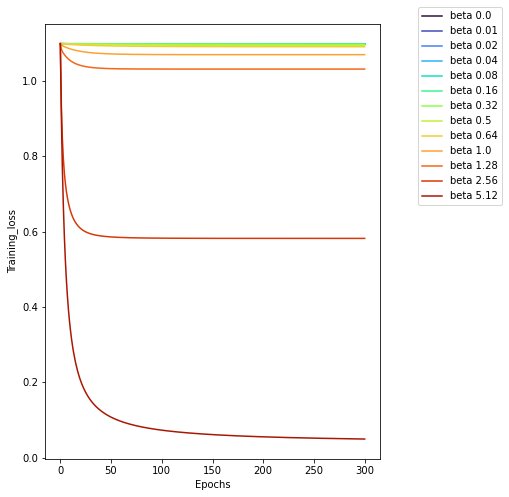

In [59]:
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(loss_beta):
    plt.plot(j,label ="beta "+str(np.around(beta[i].item(),3)),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("sin_train_loss_2.png",bbox_inches='tight')

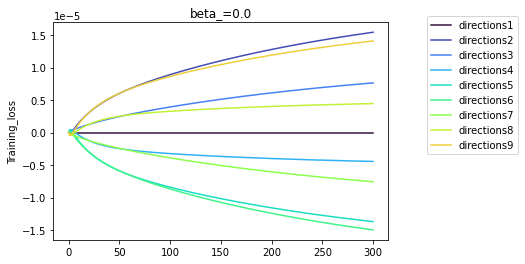

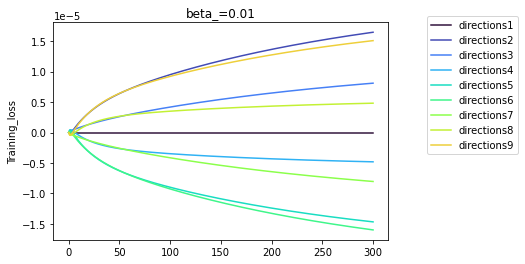

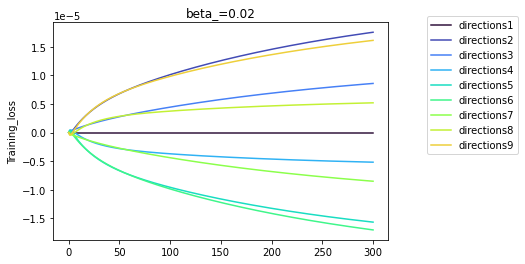

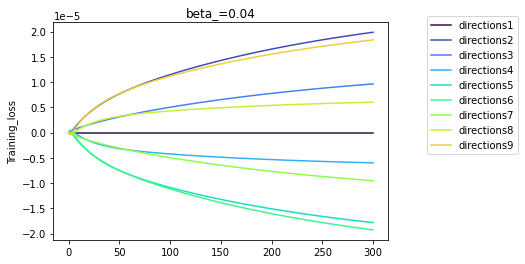

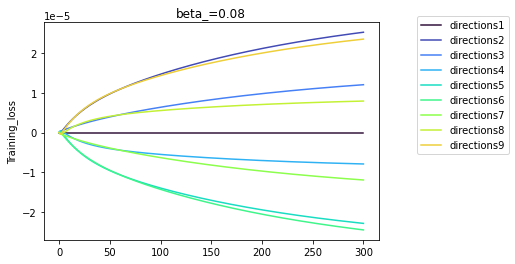

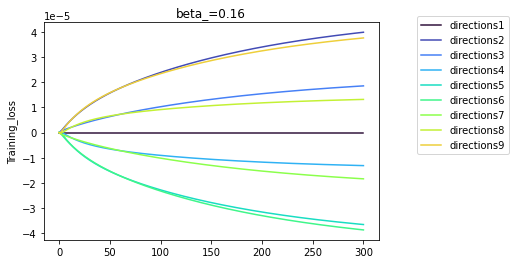

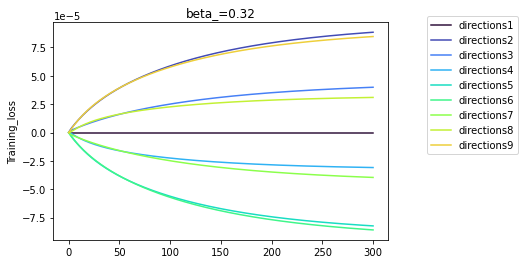

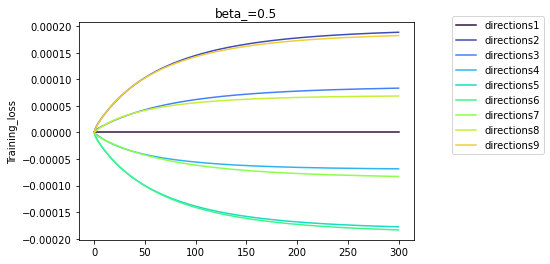

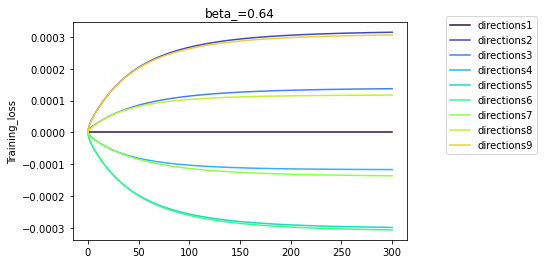

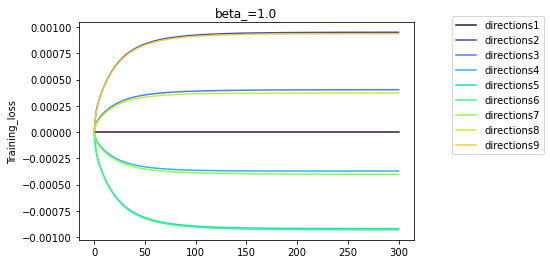

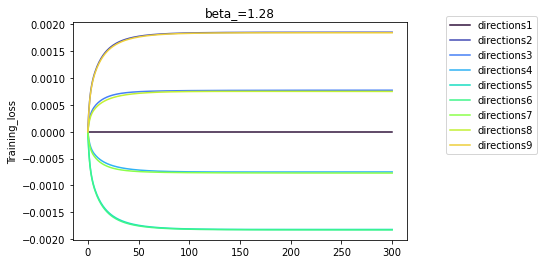

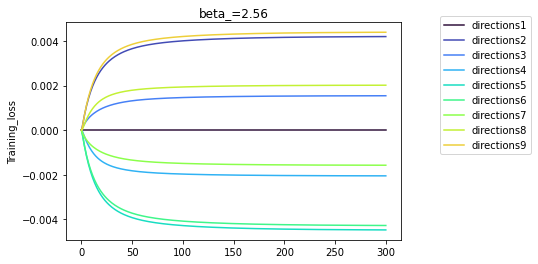

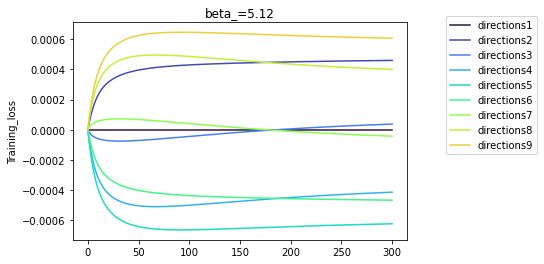

In [60]:
for j in range(len(beta)):
    plt.figure()
    for i in range(len(directions)+1):
        temp = np.array(loss_beta[j]) - test_loss_beta[j][:,i]
        plt.plot(temp,label ="directions"+str(i+1),color = cm(i*20))
        plt.ylabel("Training_loss")
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.title("beta_="+str(np.around(beta[j].item(),3)))
        plt.savefig("sin_train_loss_2_loss_beta_"+str(j)+".png",bbox_inches='tight')